# Preprocessing of data

### Import libraries and preproc

In [1]:
import sys
import numpy as np
from tqdm import tqdm
import nibabel
#!{sys.executable} -m pip install nilearn #install relevant neuroimaging package
#!{sys.executable} -m pip install opencv-python #install video package
from preprocessing import load_and_mask_miyawaki_data
from plots import plt_fmri_stim
import matplotlib.pyplot as plt

In [2]:
fmri_data, stimuli, fmri_figures_data, stimuli_figures, masker = load_and_mask_miyawaki_data()

Preprocessing data...

The shape of the masked data is (20, 145, 5438)
Preprocessed fMRI data: 2860 samples x 5438 voxels
Preprocessed stimuli data: 2860 samples x 100 pixels
1536 geometrical figures


 Done (28.82s).


In [3]:
stimuli

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

### Create data sets

In [4]:
all_fmri = np.concatenate((fmri_data, fmri_figures_data))
all_stimuli = np.concatenate((stimuli, stimuli_figures))

#erase black figs: """"""useless"""""" for our use of the data
        
stimuli2 = np.array([element for element in stimuli if np.sum(element) != 0])
fmri_data2 = np.array([fmri_data[i] for i in range(len(fmri_data)) if np.sum(stimuli[i]) != 0])

all_stimuli2 = np.array([element for element in all_stimuli if np.sum(element) != 0])
all_fmri2 = np.array([all_fmri[i] for i in range(len(all_fmri)) if np.sum(all_stimuli[i]) != 0])

stimuli_figures2 = np.concatenate((np.array([element for element in stimuli_figures if np.sum(element) != 0]),np.array([stimuli_figures[4]])))
fmri_figures_data2 = np.concatenate((np.array([fmri_figures_data[i] for i in range(len(fmri_figures_data)) if np.sum(stimuli_figures[i]) != 0]), np.array([fmri_figures_data[4]])))

In [5]:
from sklearn.model_selection import train_test_split

#random images avec les carrés noirs
train_to_test_ratio = 0.8
X_train, X_test, Y_train, Y_test = train_test_split(fmri_data, stimuli, 
                                        train_size=train_to_test_ratio, 
                                        test_size=1.0-train_to_test_ratio)

#geometric images avec les carrés noirs
train_to_test_ratio = 0.8
X_trainfig, X_testfig, Y_trainfig, Y_testfig = train_test_split(fmri_figures_data, stimuli_figures, 
                                        train_size=train_to_test_ratio, 
                                        test_size=1.0-train_to_test_ratio)

#geometric images sans les carrés noirs
train_to_test_ratio = 0.8
X_trainfig2, X_testfig2, Y_trainfig2, Y_testfig2 = train_test_split(fmri_figures_data2, stimuli_figures2, 
                                        train_size=train_to_test_ratio, 
                                        test_size=1.0-train_to_test_ratio)

#random images sans les carrés noirs
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(fmri_data2, stimuli2, 
                                        train_size=train_to_test_ratio, 
                                        test_size=1.0-train_to_test_ratio)

#avec tout
X_train_all, X_test_all, Y_train_all, Y_test_all = train_test_split(all_fmri, all_stimuli, 
                                        train_size=train_to_test_ratio, 
                                        test_size=1.0-train_to_test_ratio)

X_train_all2, X_test_all2, Y_train_all2, Y_test_all2 =train_test_split(all_fmri2, all_stimuli2, train_size=train_to_test_ratio, test_size=1.0-train_to_test_ratio)

### Manipulate stimuli images for multiscale analysis

In [6]:
# Create list pixel_indices of 4-uplets of incidices of pixels we want to average together for the 2*2 scale
n_even = [2*i for i in range(5)] #list used to generate pixel_indices
pixel_indices_22 = [[10*a+b, 10*a+(b+1), 10*(a+1)+b, 10*(a+1)+(b+1)] for a in n_even for b in n_even]

# Same for 2*1 scale
n_odd = [2*i+1 for i in range(50)]
pixel_indices_21 = [[a-1, a] for a in n_odd]

# Same for 1*2 scale
pixel_indices_12 = [[a*10 + b, (a+1)*10 +b] for a in n_even for b in range(10)]

In [7]:
# Preprocessing of stimuli data for multi scale encoding

def preproc_one_stimuli(idx_pxl_toavg, stim, reshape = False, reshape_form = (5,5)) :
    """
    Permits to preproc 1 stimuli figure by averaging some pixels together for the 
    multiscale encoding.
    - idx_pxl_toavg : liste de multiplets d'indices de pixels que l'on souhaite moyenner
                      ensemble. Par ex, pour le 2*2 on a :
                      [[0,1,10,11], [2,3,12,13], ... ,[88,89,98,99]].
    - stimuli: the image
    - reshape : if you want your image to be reshaped in such a way that you can plot it
    - reshape_form : (5,5) for a 5 by 5 image, etc...
    """
    if reshape == False :
        return np.array([np.average([stim[i] for i in idx]) for idx in idx_pxl_toavg])
    
    else :
        return np.array(np.reshape([np.average([stim[i] for i in idx]) for idx in idx_pxl_toavg],reshape_form))
    

def preproc_multiple_stimuli(idx_pxl_toavg, stimuli_list, reshape = False, reshape_form = (5,5)) :
    """
    Same as above but to preproc a whole list of stimulis
    Sorry this looks horrible
    """
    if reshape == False :
        return np.array([[np.average([stim[i] for i in idx]) for idx in idx_pxl_toavg] for stim in stimuli_list])
    
    else :
        reshape_form_multi = (len(stimuli_list),reshape_form[0],reshape_form[1])
        return np.array(np.reshape([np.average([stim[i] for i in idx]) for idx in idx_pxl_toavg for stim in stimuli_list],reshape_form_multi))
    
def Y_train_newscale(Y_train, idx_pxl_toavg, reshape = False, reshape_form = (5,5)) :
    """
    Creates a new Y_train but with rescaled images 
    Changes greyscale values to classes (integers) : for this, we want to map the values of greyscale to
    integers. We notice that for 4 pixels, only possible values are [0,0.25,0.5,0.75,1]. For 2 pixels, [0,0.5,1]. Etc.
    By multiplying these grayscale values by the number of pixels we get [0,1,2,3,4] or [0,1,2], etc. Hence the multiplication.
    """
    Y_continuous = preproc_multiple_stimuli(idx_pxl_toavg, Y_train, reshape, reshape_form) #with values in [0,1]
    n = len(idx_pxl_toavg[0]) #number of classes is the number of pixels there is to average + 1. For instance for 4 pixels you can have [0,0.25,0.5,0.75,1]
    Y_integers = [[int(pixel_val * n) for pixel_val in img] for img in Y_continuous]
    return Y_integers

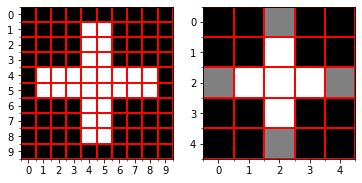

In [8]:
# Check that stimuli processing works

imag = stimuli_figures2[30]

old = np.reshape(imag,(10,10))
new = preproc_one_stimuli(pixel_indices_22, imag, reshape = True)

fig = plt.figure()
sp1 = plt.subplot(121)
sp2 = plt.subplot(122)

# to show the grid 

for ax in (sp1, sp2) :

    # Major ticks
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_yticks(np.arange(0, 10, 1))

    # Minor ticks
    ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
    
    ax.grid(which='minor', color='r', linestyle='-', linewidth=2)


sp1.imshow(old, cmap = plt.cm.gray, interpolation = 'nearest')
sp2.imshow(new, cmap = plt.cm.gray, interpolation = 'nearest')

It works !

# Train a log reg at the different scales

In [9]:
from sklearn import linear_model

def train_logreg_scale(X_train, Y_train, X_test, Y_test, scale) :
    """
    Trains a log reg for a certain scale 
    """
    logreg_table = []
    size = int(100/scale[0]*scale[1])
    
    train_accuracy, test_accuracy = np.zeros(size), np.zeros(size)

    # loop over regularisation strength
    for i, pixel in tqdm(enumerate(np.transpose(Y_train))):
    
        # define logistic regressor
        logreg = linear_model.LogisticRegression(penalty="l2", C=0.05, max_iter = 15000, multi_class='multinomial')
    
        # fit training data
        logreg.fit(X_train, pixel)
    
        logreg_table.append(logreg)
    
        # check accuracy
        train_accuracy[i]=logreg.score(X_train,pixel)
        test_accuracy[i]=logreg.score(X_test,np.transpose(Y_test)[i])
        
    return logreg_table, train_accuracy, test_accuracy

In [10]:
#Prediction functions for initial pixels
[logreg_table_11, train_accuracy_11, test_accuracy_11] = train_logreg_scale(X_train, Y_train, X_test, Y_test, (1,1))

100it [44:17, 26.57s/it]


In [11]:
print(np.average(train_accuracy_11), np.average(test_accuracy_11))

1.0 0.8451923076923077


In [ ]:
# New Y_train for 2*2 block averaged images
Y_train_22, Y_test_22 = Y_train_newscale(Y_train, pixel_indices_22), Y_train_newscale(Y_test, pixel_indices_22)

[logreg_table_22, train_accuracy_22, test_accuracy_22] = train_logreg_scale(X_train, Y_train_22, X_test, Y_test_22,(2,2))

15it [20:40, 66.86s/it]

In [ ]:
print(np.average(train_accuracy_22), np.average(test_accuracy_22))

In [ ]:
# New Y_train for 2*1 block averaged images
Y_train_21, Y_test_21 = Y_train_newscale(Y_train, pixel_indices_21),  Y_train_newscale(Y_test, pixel_indices_21)
            
[logreg_table_21, train_accuracy_21, test_accuracy_21] = train_logreg_scale(X_train, Y_train_21, X_test, Y_test_21,(2,1))

In [ ]:
print(np.average(train_accuracy_21), np.average(test_accuracy_21))

In [ ]:
# New Y_train for 1*2 block averaged images
Y_train_12, Y_test_12 = Y_train_newscale(Y_train, pixel_indices_12),  Y_train_newscale(Y_test, pixel_indices_12)

[logreg_table_12, train_accuracy_12, test_accuracy_12] = train_logreg_scale(X_train, Y_train_12, X_test, Y_test_12,(1,2))

In [ ]:
print(np.average(train_accuracy_12), np.average(test_accuracy_12))
len(Y_train_12[0])

# Check results 

In [ ]:
# Compute predictions on geometric image n°n for 2x2 and 1x1

def test_predictions(n) :
    """
    Just a function that returns the predictions for 2x2 block averaged and no averaging of the n-th geometric
    image. Only useful to check some plots.
    """
    imag = stimuli_figures2[n]

    ytest_22 = preproc_one_stimuli(pixel_indices_22, imag, reshape = True)
    ytest_11 = np.reshape(imag,(10,10))
    ytest_12 = preproc_one_stimuli(pixel_indices_12, imag, reshape = True, reshape_form = (5,10))
    ytest_21 = preproc_one_stimuli(pixel_indices_21, imag, reshape = True, reshape_form = (10,5))
    xtest = fmri_figures_data2[n].reshape(1,-1)

    ypred_22 = np.zeros(25)
    ypred_11 = np.zeros(100)
    ypred_21 = np.zeros(50)
    ypred_12 = np.zeros(50)

    for i,pixel in enumerate(ypred_22) :
        y22 = logreg_table_22[i].predict(xtest)
        ypred_22[i] = y22
    ypred_22_greyscale = [x/4 for x in ypred_22]
    ypred_22_greyscale = np.reshape(ypred_22_greyscale,(5,5))
    
    for i,pixel in enumerate(ypred_12) :
        y12 = logreg_table_12[i].predict(xtest)
        ypred_12[i] = y12
    ypred_12_greyscale = [x/2 for x in ypred_12]
    ypred_12_greyscale = np.reshape(ypred_12_greyscale,(5,10))
    
    for i,pixel in enumerate(ypred_21) :
        y21 = logreg_table_21[i].predict(xtest)
        ypred_21[i] = y21
    ypred_21_greyscale = [x/4 for x in ypred_21]
    ypred_21_greyscale = np.reshape(ypred_21_greyscale,(10,5))

    for i, pixel in enumerate(ypred_11) :
        y11 = logreg_table_11[i].predict(xtest)
        ypred_11[i] = y11
    ypred_11 = np.reshape(ypred_11,(10,10))
    
    return ytest_11, ypred_11,  ytest_22, ypred_22_greyscale, ytest_21, ypred_21_greyscale, ytest_12, ypred_12_greyscale 

In [ ]:
# Check prediction and true value for 2x2 and no block averaging : ok
ytest_11, ypred_11,  ytest_22, ypred_22_greyscale, ytest_21, ypred_21_greyscale, ytest_12, ypred_12_greyscale  = test_predictions(25)

fig = plt.figure(figsize=(6,6))
sp1 = plt.subplot(421)
sp2 = plt.subplot(422)
sp3 = plt.subplot(423)
sp4 = plt.subplot(424)
sp5 = plt.subplot(425)
sp6 = plt.subplot(426)
sp7 = plt.subplot(427)
sp8 = plt.subplot(428)
sp1.imshow(ytest_22, cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1)
sp2.imshow(ypred_22_greyscale, cmap = plt.cm.gray, interpolation = 'nearest',vmin=0, vmax = 1)
sp3.imshow(ytest_11, cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1)
sp4.imshow(ypred_11, cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1)
sp5.imshow(ytest_12, cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1, aspect = 2)
sp6.imshow(ypred_12_greyscale, cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1, aspect = 2)
sp7.imshow(ytest_21, cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1, aspect = 0.5)
sp8.imshow(ypred_21_greyscale, cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax = 1, aspect = 0.5)
print("Accuracy 1x1 : ", np.average(test_accuracy_11), "\nAccuracy 2x2 :", np.average(test_accuracy_22))

# Let's try to merge the two results of 2x2 and 1x1

Since the 2x2 block averaged predictions have 25 pixels, we have to duplicate the pixels into 4 pixels to get a 10x10 image (and not a 5x5). That way, the 1x1 and 2x2 block-avg images will have the same format and we will be able to do a linear combination of their greyscale values. 

Idea : maybe, after this manipulation (getting 10x10 pixels for every prediction), we can check what pixels are best predicted by what model (2x2 or 1x1) and adapt weights. We could also try different linear combinations.

In [ ]:
# still to add the reshaping for 2*1 and 1*2 images

def reshape_to_100_pixels(img, shape = (5,5)) :
    """
    Reshapes a 5*5 image into a 10*10 image by duplicating pixels
    Not really opti sorry
    - shape = original shape of image
    - img = img to reshape to 10*10. Can be given as a flat list bc
            we reshape it in the beggining of the function.
    """
    img = np.array(np.reshape(img,shape)) #for use of indicies
    img100 = np.zeros((10,10))
    
    if shape == (5,5) :
        for i in range(len(img[0])) :
            for j in range(len(img[0])) :
                img100[2*i, 2*j] = img[i,j]
                img100[2*i,2*j+1] = img[i,j]
                img100[2*i+1,2*j] = img[i,j]
                img100[2*i+1,2*j+1] = img[i,j]
                
    #elif shape == (1,2) :
      #  for 
            
    return img100


        

In [ ]:
default = np.zeros(100)
def avg_image(img11, img22, w11, w22 = default, w12 = default, w21 = default, reshaped = False) :
    """
    Averages values of pixels given the matrices of weights (1 weight per pixel per type of block averaging)
    Put reshaped = True if you want the output to be a 10*10 array and not a flat 100-elements long list
    """
    
    # Flatten in needed
    img11.flatten()
    img22.flatten()
    
    # Check sum of weights is one
    for i in range(len(w11)) :
        if np.any(w11 + w22) != 1 :
            print("Sum of weights is not one, see pixel no", i)
            break
    
    # Averaged image
    merged = np.array([img11[i]*w11[i] + img22[i]*w22[i] for i in range(len(img11))])
    
    # Reshapes to 10*10 format if specified in arguments of the function
    if reshaped == False :
        return merged
    else :
        return np.reshape(merged,(10,10))
    


In [ ]:
#Pas eu le temps de tester mais à moins d'être très con je pense que ça marche

#reshape all 
def reshape_all_images(img_array, shape = (5,5)):
    """
    Takes the initial stimuli and reshapes them all in the same fashion
    """
    
    reshaped_array = np.zeros(np.shape(img_array[0]))
    print("Reshaping...")
    for i in tqdm(range(np.shape(img_array)[0])):
        reshaped_array[i] = reshape_to_100_pixels(img_array[i], shape = (5,5))
    return reshaped_array

def avg_all_images(img_array_11, img_array_22, #img_array_12, img_array_21, 
                  w11, w22 = default, w12 = default, w21 = default, reshaped = False):
    
    #N images
    averages_array = np.zeros(np.shape(img_array_11)[0])
    print("Averaging...")
    for i in tqdm(range(np.shape(img_array_11)[0])):
        averages_array[i] = avg_image(img_array_11[i], img_array_22[i], #img_array_12[i], img_array_21[i], 
                                      w11, w22 = default, w12 = default, w21 = default, reshaped = False)
    return averages_array
    

In [ ]:
# Ok it works (average img 2x2 and 1x1)
fig = plt.figure()
sp1 = plt.subplot(151)
sp2 = plt.subplot(152)
sp3 = plt.subplot(153)
sp4 = plt.subplot(154)
sp5 = plt.subplot(155)

w11 = 0.5 * np.ones(100)
w22 = 0.5 * np.ones(100)

n=88
ytest_11, ypred_11,  ytest_22, ypred_22_greyscale, ytest_21, ypred_21_greyscale, ytest_12, ypred_12_greyscale  = test_predictions(n)

sp1.imshow(ypred_11, cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax=1)
sp2.imshow(ypred_22_greyscale, cmap = plt.cm.gray, interpolation = 'nearest', vmin=0, vmax=1)

ypred_22_100 = reshape_to_100_pixels(ypred_22_greyscale)
newimg = avg_image(img11 = ypred_11, img22 = ypred_22_100, w11 = w11, w22 = w22)
newimg_bin = [[round(val,0) for val in newimg[i]] for i in range(len(newimg))]

sp3.imshow(newimg, cmap = plt.cm.gray, vmin = 0, vmax = 1)

sp4.imshow(ytest_11, cmap = plt.cm.gray, vmin = 0, vmax = 1) #real value
sp5.imshow(newimg_bin, cmap = plt.cm.gray, vmin = 0, vmax = 1) #binarized avg pred

This works : now we want also to be able to do it with the 2x1 and 1x2 block averaged images. But before, let's maybe look into the optimization ?

We should try to find which pixels are best predicted by each block averaging.

Also we need better trained models on the 2x2 and 2x1 or 1x2 i don't remember which one is the worst.

In [ ]:
#Optimization of the logregs
#Idea: my laptop is too slow to optimize on all pixels; maybe optimize on a few and see if always gives the same

param_grid_lr = {
    #'penalty': ['l1', 'l2', 'elasticnet', 'none'], #problem is that some penalties incompatible with solver
    'C': [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
    'max_iter': [20, 50, 100, 200, 500, 1000],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],   
    'class_weight': [None, 'balanced']                                    
}